## LSTM Travel Time + Speed Prediction - N103.2

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
traffic = pd.read_csv('../db.csv', parse_dates = ["timeStamp"])
traffic.head(10)

,currentSpeed,freeFlowSpeed,currentTravelTime,freeFlowTravelTime,roadName,roadClosure,timeStamp
0,64,64,21,21,N103.1,False,2021-04-26 18:11:34
1,34,43,49,39,N103.0,False,2021-04-27 14:53:37
2,64,64,21,21,N103.1,False,2021-04-27 14:53:49
3,51,51,37,37,N103.2,False,2021-04-27 14:54:00
4,74,74,21,21,N101.0,False,2021-04-27 14:54:12
5,33,43,51,39,N103.0,False,2021-04-27 14:57:10
6,64,64,21,21,N103.1,False,2021-04-27 14:57:22
7,39,50,49,38,N103.2,False,2021-04-27 14:57:33
8,74,74,21,21,N101.0,False,2021-04-27 14:57:45
9,52,67,28,21,N101.1,False,2021-04-27 14:57:57


In [3]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294475 entries, 0 to 294474
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   currentSpeed        294475 non-null  int64         
 1   freeFlowSpeed       294475 non-null  int64         
 2   currentTravelTime   294475 non-null  int64         
 3   freeFlowTravelTime  294475 non-null  int64         
 4   roadName            294475 non-null  object        
 5   roadClosure         294475 non-null  bool          
 6   timeStamp           294475 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), int64(4), object(1)
memory usage: 13.8+ MB


In [4]:
print(traffic['roadName'].unique())

['N103.1' 'N103.0' 'N103.2' 'N101.0' 'N101.1' 'N101.2' 'N101.3' 'N101.4'
 'N101.5' 'Cent.0' 'Cent.1' 'Cent.2' 'Cent.3' 'Cent.4']


### Filter Roads

In [5]:
traffic = traffic[(traffic['roadName'] == 'N103.2')]

### Drop unwanted columns 

In [6]:
traffic = traffic.drop(columns = ['roadClosure', 'freeFlowTravelTime', 'freeFlowSpeed', 'roadName'])

### Remove incomplete days

In [7]:
tfc = traffic[(traffic['timeStamp'].dt.day != 26) 
                        & (traffic['timeStamp'].dt.day != 27) 
                        & (traffic['timeStamp'].dt.day != 3)]

### Treat Date and Time

In [8]:
tfc['timeStamp'] = pd.to_datetime(tfc['timeStamp']).dt.strftime("%Y%m%d%H")

<ipython-input-8-7e39a034e481>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tfc['timeStamp'] = pd.to_datetime(tfc['timeStamp']).dt.strftime("%Y%m%d%H")


In [9]:
tfc

,currentSpeed,currentTravelTime,timeStamp
6392,51,37,2021042800
6406,51,37,2021042800
6420,51,37,2021042800
6434,51,37,2021042800
6448,51,37,2021042800
...,...,...,...
294417,39,49,2021051509
294431,37,52,2021051509
294445,33,58,2021051509
294459,32,60,2021051509


In [10]:
traffic_by_date = tfc.groupby(['timeStamp'])
traffic_by_date_mean = traffic_by_date.mean()
traffic_by_date_mean

,currentSpeed,currentTravelTime
timeStamp,,
2021042800,51.000000,37.000000
2021042801,51.000000,37.000000
2021042802,51.000000,37.000000
2021042803,51.000000,37.000000
2021042804,51.000000,37.000000
...,...,...
2021051505,50.000000,38.000000
2021051506,50.000000,38.000000
2021051507,50.000000,38.000000


### Normalize Data

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-1, 1))

normalized_Time = traffic_by_date_mean
normalized_Speed = traffic_by_date_mean

normalized_Time[['currentTravelTime']] = scaler.fit_transform(traffic_by_date_mean[['currentTravelTime']])
normalized_Time = normalized_Time.drop(columns = ['currentSpeed'])
normalized_Time

normalized_Speed[['currentSpeed']] = scaler.fit_transform(traffic_by_date_mean[['currentSpeed']])
normalized_Speed = normalized_Speed.drop(columns = ['currentTravelTime'])
normalized_Speed

,currentSpeed
timeStamp,
2021042800,1.000000
2021042801,1.000000
2021042802,1.000000
2021042803,1.000000
2021042804,1.000000
...,...
2021051505,0.903435
2021051506,0.903435
2021051507,0.903435


In [12]:
# 24 hours that make the sequence
TIMESTEPS = 24

# number of features used by the model (using conf. cases to predict conf. cases)
FEATURES = len(normalized_Time.columns)

# number of hours to forecast - we will forecast the next 12 hours
MULTISTEPS = 12

# time series cross validator
CV_SPLITS = 5

EPOCHS = 300

# 24 hours (1 day)
BATCH_SIZE = 24

In [13]:
# split data into training and validation sets
def split_data(training, percentage = 15):
    train_idx = np.arange(0, int(len(training) * (100 - percentage) / 100))
    val_idx = np.arange(int(len(training) * (100 - percentage) / 100 + 1), len(training))
    
    return train_idx, val_idx

In [14]:
# Preparing the dataset for the LSTM
def to_supervised(df, timesteps, features = 1):

    data = df.values
    x, y = [], []
    
    # iterate over the training set to create x and y
    dataset_size = len(data)
    
    for curr_pos in range(dataset_size):
        # end of the input sequence is the current position + the number 
        # of timesteps of the input sequence
        input_index = curr_pos + timesteps
        
        # end of the labels correspond to the end of the input sequence + 1
        label_index = input_index + 1
        
        # if we have enough data for this sequence 
        if label_index < dataset_size:
            x.append(data[curr_pos:input_index, :])
            y.append(data[input_index:label_index, 0])
        
    # using np.float32 for GPU performance
    return np.array(x).astype('float32'), np.array(y).astype('float32')


def rmse(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))
    

def build_model(timesteps, features, name, h_neurons = 128):
    
    model = tf.keras.models.Sequential(name = name)
    
    model.add(LSTM(h_neurons, return_sequences = True,
                   input_shape = (timesteps, features), 
                   activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(LSTM(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(Dense(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(Dense(features, activation = 'tanh'))
    
    return model


# Compiling and fit the model
def compile_and_fit(model, x, y, epochs, batch_size, cv_splits):
    callback = []
    
    callback.append(EarlyStopping(monitor = 'val_loss', min_delta = 0, 
                                  patience = 20, verbose = 0, 
                                  mode = 'auto', restore_best_weights = True))
    
    callback.append(ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, 
                                      patience = 20, verbose = 0,
                                      mode = 'auto', cooldown = 0, 
                                      min_lr = 0.0001))
    
    # compile
    model.compile(loss = rmse, 
                  optimizer = 'Rmsprop', 
                  metrics = ['mae', rmse])    
    
    # fit
    hist_list = []
    loss_list = []
    
    # time series cross validator
    tscv = TimeSeriesSplit(n_splits = cv_splits)
    
    for train_index, test_index in tscv.split(x):
        # further split into training and validation sets
        train_idx, val_idx = split_data(train_index, percentage = 15)
        
        x_train, y_train = x[train_idx], y[train_idx]
        x_val, y_val = x[val_idx], y[val_idx]
        #x_test, y_test = x[test_index], y[test_index]
        
        history = model.fit(x_train, y_train, validation_data = (x_val, y_val), 
                            epochs = epochs, batch_size = batch_size, 
                            shuffle = False, callbacks = callback)
        
        plot_learning_curves(history, model_name = model.get_config()['name'])
    
    return model, hist_list, loss_list


# Recursive Multi-step Forecast
def forecast(model, df, scaler, timesteps, multisteps, features, batch_size):
    # getting the last sequence of known value
    input_seq = df[-timesteps:].values
    inp = input_seq
    forecasts = []
    
    # multisteps tells us how many iterations we want to perform, i.e., how many days
    # we want to predict
    for step in range(1, multisteps + 1):
     
        inp = inp.reshape(1, timesteps, features)
        
        yhat = model.predict(inp)
        
        print('yhat', yhat[0][features-1])
        
        yhat_inversed = scaler.inverse_transform(yhat)
        
        print('Transformed yhat', yhat_inversed[0][features-1])
        
        forecasts.append(round(yhat_inversed[0][features-1],1))
    
        inp = np.append(inp[0], yhat[0])
        
        inp = inp[-timesteps*features:]
        
    return forecasts


def plot_prediction(data, forecasts, scaler):
    
    d = data.values[-24:, -1]
    d = scaler.inverse_transform([d])[0]
    
    print('Real data:', d)
    print('Forecasting values:', forecasts)
    
    f = []; f.append(round(d[-1])); f.extend(forecasts)
    
    plt.figure(figsize = (8, 6))
    plt.plot(range(len(d)), d, color = 'mediumpurple', label = 'Real', linewidth=3)
    plt.plot(range(len(d) - 1, len(d) + len(f) - 1),
             f, color = 'purple', label = 'predicted', linewidth=3)
    plt.title('Current Travel Time For The Next 12H')
    plt.ylabel('Current Travel Time (min)')
    plt.xlabel('Hours')
    plt.legend()
    plt.show()

def plot_prediction_Speed(data, forecasts, scaler):
    
    d = data.values[-24:, -1]
    d = scaler.inverse_transform([d])[0]
    
    print('Real data:', d)
    print('Forecasting values:', forecasts)
    
    f = []; f.append(round(d[-1])); f.extend(forecasts)
    
    plt.figure(figsize = (8, 6))
    plt.plot(range(len(d)), d, color = 'mediumpurple', label = 'Real', linewidth=3)
    plt.plot(range(len(d) - 1, len(d) + len(f) - 1),
             f, color = 'purple', label = 'predicted', linewidth=3)
    plt.title('Current Speed For The Next 12H')
    plt.ylabel('Current Speed (KM/H)')
    plt.xlabel('Hours')
    plt.legend()
    plt.show()



def plot_learning_curves(history, model_name):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['rmse'], color = 'mediumpurple',linewidth=3)
    plt.plot(history.history['val_rmse'], color = 'purple',linewidth=3)
    plt.title('Model ({}) rmse'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'], color = 'mediumpurple', linewidth=3)
    plt.plot(history.history['val_loss'], color = 'purple', linewidth=3)
    plt.title('Model ({}) loss'.format(model_name))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

# LSTM - Time

In [15]:
# our supervised problem
x, y = to_supervised(normalized_Time, TIMESTEPS, FEATURES)
print('Training shape:', x.shape)
print('Training labels shape:', y.shape)

Training shape: (352, 24, 1)
Training labels shape: (352, 1)


Epoch 1/300
3/3 [==============================] - 12s 2s/step - loss: 0.5758 - mae: 0.5241 - rmse: 0.5147 - val_loss: 0.0343 - val_mae: 0.0134 - val_rmse: 0.0343
Epoch 2/300
3/3 [==============================] - 0s 144ms/step - loss: 0.3416 - mae: 0.2094 - rmse: 0.3027 - val_loss: 0.0659 - val_mae: 0.0653 - val_rmse: 0.0659
Epoch 3/300
3/3 [==============================] - 0s 93ms/step - loss: 0.3598 - mae: 0.3020 - rmse: 0.3165 - val_loss: 0.0357 - val_mae: 0.0308 - val_rmse: 0.0357
Epoch 4/300
3/3 [==============================] - 0s 122ms/step - loss: 0.3071 - mae: 0.2082 - rmse: 0.2713 - val_loss: 0.0334 - val_mae: 0.0174 - val_rmse: 0.0334
Epoch 5/300
3/3 [==============================] - 1s 206ms/step - loss: 0.3333 - mae: 0.1999 - rmse: 0.2949 - val_loss: 0.0333 - val_mae: 0.0182 - val_rmse: 0.0333
Epoch 6/300
3/3 [==============================] - 0s 117ms/step - loss: 0.3282 - mae: 0.1971 - rmse: 0.2914 - val_loss: 0.0337 - val_mae: 0.0249 - val_rmse: 0.0337
Epoch 7/300
3

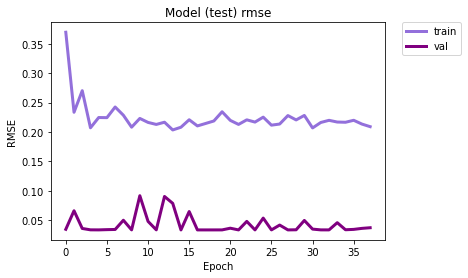

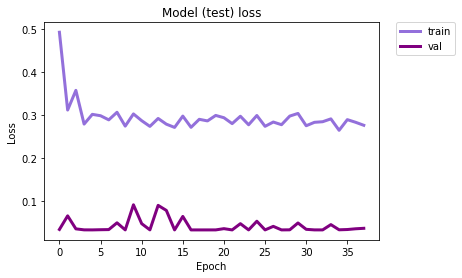

Epoch 1/300
5/5 [==============================] - 0s 100ms/step - loss: 0.2558 - mae: 0.1539 - rmse: 0.2746 - val_loss: 0.3274 - val_mae: 0.2462 - val_rmse: 0.3274
Epoch 2/300
5/5 [==============================] - 0s 88ms/step - loss: 0.2519 - mae: 0.1520 - rmse: 0.2676 - val_loss: 0.3094 - val_mae: 0.2370 - val_rmse: 0.3094
Epoch 3/300
5/5 [==============================] - 0s 104ms/step - loss: 0.2333 - mae: 0.1491 - rmse: 0.2483 - val_loss: 0.2854 - val_mae: 0.2245 - val_rmse: 0.2854
Epoch 4/300
5/5 [==============================] - 0s 97ms/step - loss: 0.2237 - mae: 0.1552 - rmse: 0.2403 - val_loss: 0.2678 - val_mae: 0.2161 - val_rmse: 0.2678
Epoch 5/300
5/5 [==============================] - 1s 113ms/step - loss: 0.2211 - mae: 0.1616 - rmse: 0.2374 - val_loss: 0.2599 - val_mae: 0.2118 - val_rmse: 0.2599
Epoch 6/300
5/5 [==============================] - 1s 113ms/step - loss: 0.2198 - mae: 0.1669 - rmse: 0.2392 - val_loss: 0.2565 - val_mae: 0.2097 - val_rmse: 0.2565
Epoch 7/300


5/5 [==============================] - 1s 109ms/step - loss: 0.2125 - mae: 0.1612 - rmse: 0.2297 - val_loss: 0.2434 - val_mae: 0.1897 - val_rmse: 0.2434
Epoch 51/300
5/5 [==============================] - 0s 91ms/step - loss: 0.2166 - mae: 0.1665 - rmse: 0.2358 - val_loss: 0.2410 - val_mae: 0.1884 - val_rmse: 0.2410
Epoch 52/300
5/5 [==============================] - 0s 94ms/step - loss: 0.2152 - mae: 0.1633 - rmse: 0.2309 - val_loss: 0.2366 - val_mae: 0.1861 - val_rmse: 0.2366
Epoch 53/300
5/5 [==============================] - 0s 107ms/step - loss: 0.2128 - mae: 0.1656 - rmse: 0.2336 - val_loss: 0.2395 - val_mae: 0.1870 - val_rmse: 0.2395
Epoch 54/300
5/5 [==============================] - 1s 148ms/step - loss: 0.2089 - mae: 0.1608 - rmse: 0.2329 - val_loss: 0.2387 - val_mae: 0.1862 - val_rmse: 0.2387
Epoch 55/300
5/5 [==============================] - 0s 95ms/step - loss: 0.2199 - mae: 0.1659 - rmse: 0.2358 - val_loss: 0.2412 - val_mae: 0.1870 - val_rmse: 0.2412
Epoch 56/300
5/5 [==

5/5 [==============================] - 1s 126ms/step - loss: 0.1996 - mae: 0.1467 - rmse: 0.2188 - val_loss: 0.2238 - val_mae: 0.1623 - val_rmse: 0.2238
Epoch 100/300
5/5 [==============================] - 0s 95ms/step - loss: 0.2006 - mae: 0.1444 - rmse: 0.2201 - val_loss: 0.2195 - val_mae: 0.1603 - val_rmse: 0.2195
Epoch 101/300
5/5 [==============================] - 1s 128ms/step - loss: 0.2091 - mae: 0.1535 - rmse: 0.2264 - val_loss: 0.2166 - val_mae: 0.1587 - val_rmse: 0.2166
Epoch 102/300
5/5 [==============================] - 1s 114ms/step - loss: 0.2103 - mae: 0.1533 - rmse: 0.2184 - val_loss: 0.2169 - val_mae: 0.1582 - val_rmse: 0.2169
Epoch 103/300
5/5 [==============================] - 1s 142ms/step - loss: 0.1989 - mae: 0.1463 - rmse: 0.2148 - val_loss: 0.2117 - val_mae: 0.1553 - val_rmse: 0.2117
Epoch 104/300
5/5 [==============================] - 1s 170ms/step - loss: 0.1980 - mae: 0.1464 - rmse: 0.2129 - val_loss: 0.2114 - val_mae: 0.1548 - val_rmse: 0.2114
Epoch 105/300

5/5 [==============================] - 0s 94ms/step - loss: 0.1978 - mae: 0.1400 - rmse: 0.2204 - val_loss: 0.2074 - val_mae: 0.1364 - val_rmse: 0.2074
Epoch 149/300
5/5 [==============================] - 0s 82ms/step - loss: 0.1951 - mae: 0.1343 - rmse: 0.2121 - val_loss: 0.1965 - val_mae: 0.1328 - val_rmse: 0.1965
Epoch 150/300
5/5 [==============================] - 0s 92ms/step - loss: 0.1993 - mae: 0.1421 - rmse: 0.2106 - val_loss: 0.1999 - val_mae: 0.1326 - val_rmse: 0.1999
Epoch 151/300
5/5 [==============================] - 0s 89ms/step - loss: 0.2049 - mae: 0.1364 - rmse: 0.2230 - val_loss: 0.1972 - val_mae: 0.1324 - val_rmse: 0.1972
Epoch 152/300
5/5 [==============================] - 0s 96ms/step - loss: 0.2003 - mae: 0.1384 - rmse: 0.2145 - val_loss: 0.1979 - val_mae: 0.1323 - val_rmse: 0.1979
Epoch 153/300
5/5 [==============================] - 0s 86ms/step - loss: 0.1999 - mae: 0.1411 - rmse: 0.2208 - val_loss: 0.2012 - val_mae: 0.1327 - val_rmse: 0.2012
Epoch 154/300
5/5 

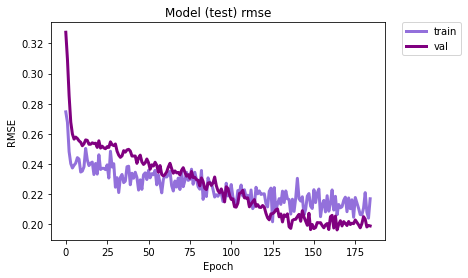

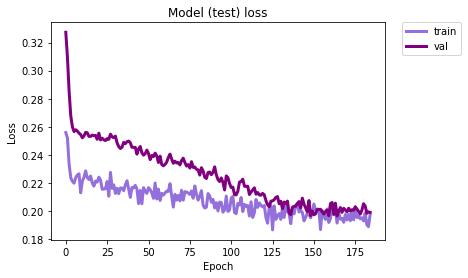

Epoch 1/300
7/7 [==============================] - 1s 97ms/step - loss: 0.2126 - mae: 0.1478 - rmse: 0.2150 - val_loss: 0.2094 - val_mae: 0.1448 - val_rmse: 0.1149
Epoch 2/300
7/7 [==============================] - 1s 100ms/step - loss: 0.2146 - mae: 0.1504 - rmse: 0.2180 - val_loss: 0.2088 - val_mae: 0.1441 - val_rmse: 0.1144
Epoch 3/300
7/7 [==============================] - 1s 100ms/step - loss: 0.2079 - mae: 0.1433 - rmse: 0.2123 - val_loss: 0.2084 - val_mae: 0.1445 - val_rmse: 0.1140
Epoch 4/300
7/7 [==============================] - 1s 100ms/step - loss: 0.2077 - mae: 0.1486 - rmse: 0.2114 - val_loss: 0.2064 - val_mae: 0.1490 - val_rmse: 0.1133
Epoch 5/300
7/7 [==============================] - 1s 141ms/step - loss: 0.2124 - mae: 0.1514 - rmse: 0.2208 - val_loss: 0.2143 - val_mae: 0.1429 - val_rmse: 0.1181
Epoch 6/300
7/7 [==============================] - 1s 105ms/step - loss: 0.2065 - mae: 0.1424 - rmse: 0.2092 - val_loss: 0.2071 - val_mae: 0.1435 - val_rmse: 0.1133
Epoch 7/300

7/7 [==============================] - 1s 78ms/step - loss: 0.1979 - mae: 0.1373 - rmse: 0.1983 - val_loss: 0.1875 - val_mae: 0.1383 - val_rmse: 0.1033
Epoch 51/300
7/7 [==============================] - 1s 104ms/step - loss: 0.2089 - mae: 0.1464 - rmse: 0.2118 - val_loss: 0.1886 - val_mae: 0.1378 - val_rmse: 0.1041
Epoch 52/300
7/7 [==============================] - 1s 113ms/step - loss: 0.1978 - mae: 0.1407 - rmse: 0.1993 - val_loss: 0.1900 - val_mae: 0.1433 - val_rmse: 0.1045
Epoch 53/300
7/7 [==============================] - 1s 75ms/step - loss: 0.2010 - mae: 0.1390 - rmse: 0.1999 - val_loss: 0.1886 - val_mae: 0.1400 - val_rmse: 0.1039
Epoch 54/300
7/7 [==============================] - 1s 92ms/step - loss: 0.2033 - mae: 0.1425 - rmse: 0.2065 - val_loss: 0.1915 - val_mae: 0.1361 - val_rmse: 0.1064
Epoch 55/300
7/7 [==============================] - 1s 94ms/step - loss: 0.1973 - mae: 0.1359 - rmse: 0.1968 - val_loss: 0.1918 - val_mae: 0.1327 - val_rmse: 0.1073
Epoch 56/300
7/7 [===

7/7 [==============================] - 1s 114ms/step - loss: 0.1985 - mae: 0.1363 - rmse: 0.1989 - val_loss: 0.1797 - val_mae: 0.1321 - val_rmse: 0.0994
Epoch 100/300
7/7 [==============================] - 1s 115ms/step - loss: 0.1979 - mae: 0.1388 - rmse: 0.1981 - val_loss: 0.1760 - val_mae: 0.1295 - val_rmse: 0.0979
Epoch 101/300
7/7 [==============================] - 1s 84ms/step - loss: 0.1947 - mae: 0.1369 - rmse: 0.1938 - val_loss: 0.1750 - val_mae: 0.1265 - val_rmse: 0.0984
Epoch 102/300
7/7 [==============================] - 1s 90ms/step - loss: 0.1946 - mae: 0.1304 - rmse: 0.1929 - val_loss: 0.1717 - val_mae: 0.1274 - val_rmse: 0.0962
Epoch 103/300
7/7 [==============================] - 1s 84ms/step - loss: 0.1981 - mae: 0.1363 - rmse: 0.2005 - val_loss: 0.1732 - val_mae: 0.1256 - val_rmse: 0.0976
Epoch 104/300
7/7 [==============================] - 1s 86ms/step - loss: 0.1954 - mae: 0.1325 - rmse: 0.1931 - val_loss: 0.1741 - val_mae: 0.1292 - val_rmse: 0.0968
Epoch 105/300
7/

7/7 [==============================] - 1s 165ms/step - loss: 0.1904 - mae: 0.1300 - rmse: 0.1911 - val_loss: 0.1688 - val_mae: 0.1259 - val_rmse: 0.0927
Epoch 149/300
7/7 [==============================] - 1s 95ms/step - loss: 0.1907 - mae: 0.1332 - rmse: 0.1859 - val_loss: 0.1674 - val_mae: 0.1225 - val_rmse: 0.0941
Epoch 150/300
7/7 [==============================] - 1s 101ms/step - loss: 0.1912 - mae: 0.1281 - rmse: 0.1882 - val_loss: 0.1648 - val_mae: 0.1226 - val_rmse: 0.0905
Epoch 151/300
7/7 [==============================] - 1s 84ms/step - loss: 0.1891 - mae: 0.1282 - rmse: 0.1874 - val_loss: 0.1718 - val_mae: 0.1278 - val_rmse: 0.0949
Epoch 152/300
7/7 [==============================] - 1s 95ms/step - loss: 0.1996 - mae: 0.1365 - rmse: 0.1962 - val_loss: 0.1660 - val_mae: 0.1225 - val_rmse: 0.0926
Epoch 153/300
7/7 [==============================] - 1s 83ms/step - loss: 0.1932 - mae: 0.1307 - rmse: 0.1908 - val_loss: 0.1676 - val_mae: 0.1253 - val_rmse: 0.0920
Epoch 154/300
7/

7/7 [==============================] - 1s 118ms/step - loss: 0.1911 - mae: 0.1259 - rmse: 0.1873 - val_loss: 0.1538 - val_mae: 0.1156 - val_rmse: 0.0868
Epoch 198/300
7/7 [==============================] - 1s 95ms/step - loss: 0.1969 - mae: 0.1325 - rmse: 0.1961 - val_loss: 0.1598 - val_mae: 0.1166 - val_rmse: 0.0879
Epoch 199/300
7/7 [==============================] - 1s 116ms/step - loss: 0.1919 - mae: 0.1328 - rmse: 0.1891 - val_loss: 0.1541 - val_mae: 0.1169 - val_rmse: 0.0842
Epoch 200/300
7/7 [==============================] - 1s 89ms/step - loss: 0.1898 - mae: 0.1286 - rmse: 0.1856 - val_loss: 0.1512 - val_mae: 0.1151 - val_rmse: 0.0841
Epoch 201/300
7/7 [==============================] - 1s 82ms/step - loss: 0.1797 - mae: 0.1199 - rmse: 0.1752 - val_loss: 0.1506 - val_mae: 0.1139 - val_rmse: 0.0850
Epoch 202/300
7/7 [==============================] - 1s 83ms/step - loss: 0.1843 - mae: 0.1249 - rmse: 0.1786 - val_loss: 0.1619 - val_mae: 0.1198 - val_rmse: 0.0911
Epoch 203/300
7/

7/7 [==============================] - 0s 60ms/step - loss: 0.1749 - mae: 0.1189 - rmse: 0.1664 - val_loss: 0.1431 - val_mae: 0.1081 - val_rmse: 0.0784
Epoch 247/300
7/7 [==============================] - 0s 57ms/step - loss: 0.1766 - mae: 0.1218 - rmse: 0.1704 - val_loss: 0.1354 - val_mae: 0.1053 - val_rmse: 0.0749
Epoch 248/300
7/7 [==============================] - 0s 75ms/step - loss: 0.1746 - mae: 0.1199 - rmse: 0.1709 - val_loss: 0.1377 - val_mae: 0.1050 - val_rmse: 0.0752
Epoch 249/300
7/7 [==============================] - 0s 60ms/step - loss: 0.1793 - mae: 0.1255 - rmse: 0.1770 - val_loss: 0.1409 - val_mae: 0.1083 - val_rmse: 0.0771
Epoch 250/300
7/7 [==============================] - 0s 63ms/step - loss: 0.1781 - mae: 0.1240 - rmse: 0.1725 - val_loss: 0.1417 - val_mae: 0.1071 - val_rmse: 0.0795
Epoch 251/300
7/7 [==============================] - 0s 65ms/step - loss: 0.1747 - mae: 0.1181 - rmse: 0.1662 - val_loss: 0.1502 - val_mae: 0.1111 - val_rmse: 0.0853
Epoch 252/300
7/7 

7/7 [==============================] - 0s 48ms/step - loss: 0.1769 - mae: 0.1156 - rmse: 0.1708 - val_loss: 0.1386 - val_mae: 0.1048 - val_rmse: 0.0776
Epoch 296/300
7/7 [==============================] - 0s 45ms/step - loss: 0.1727 - mae: 0.1200 - rmse: 0.1659 - val_loss: 0.1530 - val_mae: 0.1134 - val_rmse: 0.0896
Epoch 297/300
7/7 [==============================] - 0s 45ms/step - loss: 0.1707 - mae: 0.1222 - rmse: 0.1607 - val_loss: 0.1424 - val_mae: 0.1072 - val_rmse: 0.0803
Epoch 298/300
7/7 [==============================] - 0s 45ms/step - loss: 0.1835 - mae: 0.1315 - rmse: 0.1834 - val_loss: 0.1415 - val_mae: 0.1068 - val_rmse: 0.0797
Epoch 299/300
7/7 [==============================] - 0s 45ms/step - loss: 0.1734 - mae: 0.1268 - rmse: 0.1685 - val_loss: 0.1231 - val_mae: 0.0973 - val_rmse: 0.0694
Epoch 300/300
7/7 [==============================] - 0s 50ms/step - loss: 0.1746 - mae: 0.1170 - rmse: 0.1686 - val_loss: 0.1220 - val_mae: 0.0968 - val_rmse: 0.0683
dict_keys(['loss',

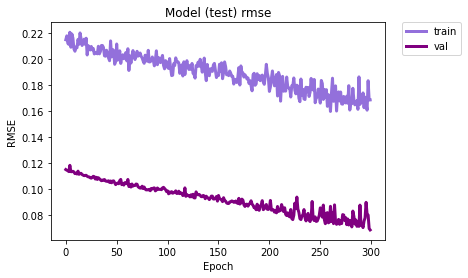

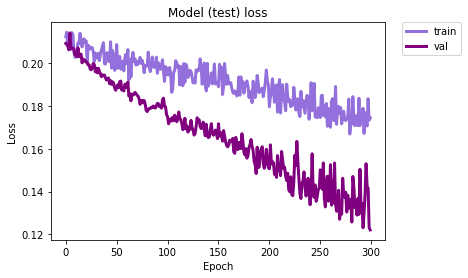

Epoch 1/300
9/9 [==============================] - 0s 52ms/step - loss: 0.1676 - mae: 0.1167 - rmse: 0.1591 - val_loss: 0.1272 - val_mae: 0.0964 - val_rmse: 0.1504
Epoch 2/300
9/9 [==============================] - 0s 45ms/step - loss: 0.1556 - mae: 0.1075 - rmse: 0.1484 - val_loss: 0.1271 - val_mae: 0.0976 - val_rmse: 0.1488
Epoch 3/300
9/9 [==============================] - 0s 44ms/step - loss: 0.1648 - mae: 0.1162 - rmse: 0.1562 - val_loss: 0.1280 - val_mae: 0.0943 - val_rmse: 0.1519
Epoch 4/300
9/9 [==============================] - 0s 44ms/step - loss: 0.1649 - mae: 0.1119 - rmse: 0.1569 - val_loss: 0.1295 - val_mae: 0.0922 - val_rmse: 0.1555
Epoch 5/300
9/9 [==============================] - 0s 44ms/step - loss: 0.1582 - mae: 0.1107 - rmse: 0.1513 - val_loss: 0.1302 - val_mae: 0.0922 - val_rmse: 0.1564
Epoch 6/300
9/9 [==============================] - 0s 44ms/step - loss: 0.1625 - mae: 0.1102 - rmse: 0.1548 - val_loss: 0.1282 - val_mae: 0.0947 - val_rmse: 0.1519
Epoch 7/300
9/9 

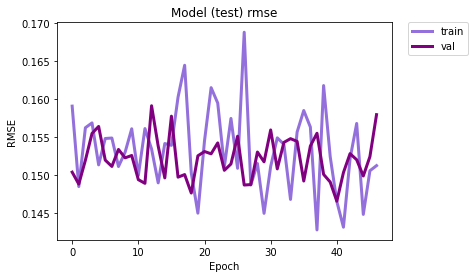

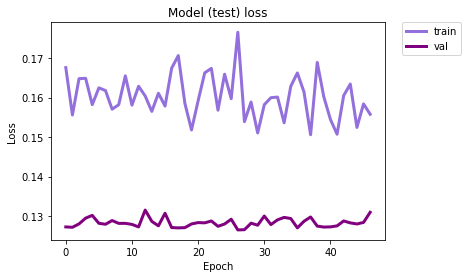

Epoch 1/300
11/11 [==============================] - 2s 138ms/step - loss: 0.1727 - mae: 0.1194 - rmse: 0.1747 - val_loss: 0.1538 - val_mae: 0.1151 - val_rmse: 0.1525
Epoch 2/300
11/11 [==============================] - 1s 105ms/step - loss: 0.1706 - mae: 0.1193 - rmse: 0.1720 - val_loss: 0.1631 - val_mae: 0.1221 - val_rmse: 0.1627
Epoch 3/300
11/11 [==============================] - 1s 141ms/step - loss: 0.1637 - mae: 0.1198 - rmse: 0.1652 - val_loss: 0.1553 - val_mae: 0.1148 - val_rmse: 0.1548
Epoch 4/300
11/11 [==============================] - 2s 137ms/step - loss: 0.1692 - mae: 0.1208 - rmse: 0.1734 - val_loss: 0.1665 - val_mae: 0.1238 - val_rmse: 0.1663
Epoch 5/300
11/11 [==============================] - 1s 117ms/step - loss: 0.1640 - mae: 0.1133 - rmse: 0.1649 - val_loss: 0.1620 - val_mae: 0.1204 - val_rmse: 0.1618
Epoch 6/300
11/11 [==============================] - 1s 112ms/step - loss: 0.1678 - mae: 0.1216 - rmse: 0.1678 - val_loss: 0.1484 - val_mae: 0.1085 - val_rmse: 0.147

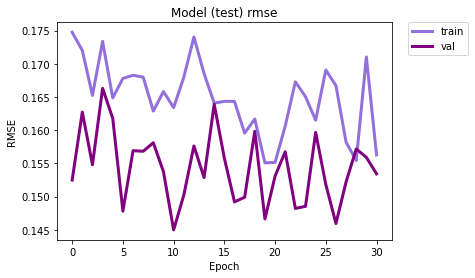

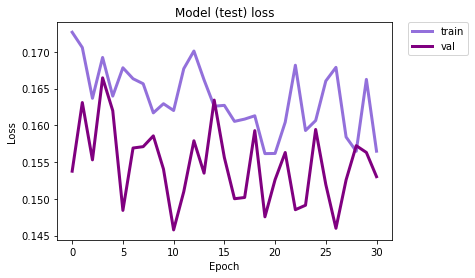

In [16]:
# fitting the model
modelTime = build_model(TIMESTEPS, FEATURES, name = 'test')
modelTime, hist_list, loss_list = compile_and_fit(modelTime, x, y, EPOCHS, BATCH_SIZE, CV_SPLITS)

yhat -0.8124183
Transformed yhat 32.231014
yhat -0.7996466
Transformed yhat 32.363274
yhat -0.78549725
Transformed yhat 32.509804
yhat -0.75505453
Transformed yhat 32.82506
yhat -0.6987548
Transformed yhat 33.40809
yhat -0.62194717
Transformed yhat 34.203487
yhat -0.53187704
Transformed yhat 35.136234
yhat -0.52302915
Transformed yhat 35.227863
yhat -0.62214214
Transformed yhat 34.20147
yhat -0.7725155
Transformed yhat 32.644238
yhat -0.86350787
Transformed yhat 31.70194
yhat -0.9103755
Transformed yhat 31.21659
Real data: [33.00089201 34.26669289 32.91788619 31.87660923 33.3625494  33.98970445
 38.33926965 37.5675726  35.68973612 31.93950617 31.31401426 30.98032786
 30.68942952 30.68942952 30.68942952 30.68942952 30.68942952 30.68942952
 30.68942952 30.68942952 30.68942952 30.68942952 32.41123321 32.56395484]
Forecasting values: [32.2, 32.4, 32.5, 32.8, 33.4, 34.2, 35.1, 35.2, 34.2, 32.6, 31.7, 31.2]


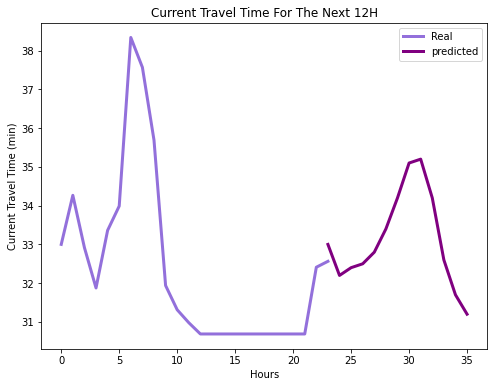

In [17]:
# Recursive Multi-step Forecast
forecasts = forecast(modelTime,normalized_Time, scaler, TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

plot_prediction(normalized_Time, forecasts, scaler)

In [18]:
hour = []
ts = traffic.iloc[-1]['timeStamp']
tss = pd.to_datetime(ts).hour

for i in range(12):
    if tss == 23:
        newHour =  ts + pd.DateOffset(hour=0)
        day = pd.to_datetime(ts).day
        newDay = newHour + pd.DateOffset(day=day+1)
        tss = 0
        ts = newDay
        hour.append(newDay)
    else: 
        h = pd.to_datetime(ts).hour
        newHour = ts + pd.DateOffset(hour=h+1)
        tss = tss+1
        ts = newHour
        hour.append(newHour)

In [19]:
import csv

with open('predictionsTime.csv', mode='a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(12):
        d = 'N103.2',forecasts[i],hour[i]
        writer.writerow(d)     

# LSTM - Speed

In [20]:
# our supervised problem
x, y = to_supervised(normalized_Speed, TIMESTEPS, FEATURES)
print('Training shape:', x.shape)
print('Training labels shape:', y.shape)

Training shape: (352, 24, 1)
Training labels shape: (352, 1)


Epoch 1/300
3/3 [==============================] - 7s 533ms/step - loss: 0.6176 - mae: 0.5214 - rmse: 0.5556 - val_loss: 0.1944 - val_mae: 0.1880 - val_rmse: 0.1944
Epoch 2/300
3/3 [==============================] - 0s 68ms/step - loss: 0.6370 - mae: 0.5714 - rmse: 0.5695 - val_loss: 0.0775 - val_mae: 0.0313 - val_rmse: 0.0775
Epoch 3/300
3/3 [==============================] - 0s 67ms/step - loss: 0.6460 - mae: 0.4461 - rmse: 0.5819 - val_loss: 0.0760 - val_mae: 0.0455 - val_rmse: 0.0760
Epoch 4/300
3/3 [==============================] - 0s 88ms/step - loss: 0.6139 - mae: 0.4436 - rmse: 0.5499 - val_loss: 0.0760 - val_mae: 0.0445 - val_rmse: 0.0760
Epoch 5/300
3/3 [==============================] - 0s 85ms/step - loss: 0.5962 - mae: 0.4310 - rmse: 0.5346 - val_loss: 0.0761 - val_mae: 0.0468 - val_rmse: 0.0761
Epoch 6/300
3/3 [==============================] - 0s 72ms/step - loss: 0.5948 - mae: 0.4288 - rmse: 0.5343 - val_loss: 0.0761 - val_mae: 0.0423 - val_rmse: 0.0761
Epoch 7/300
3/3

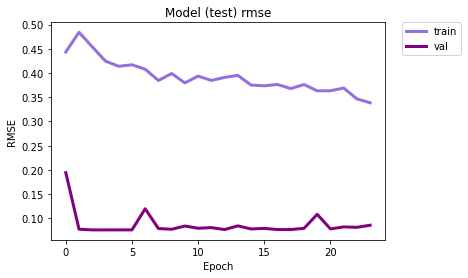

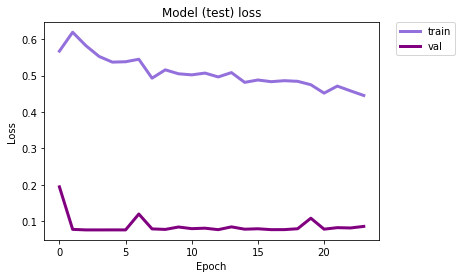

Epoch 1/300
5/5 [==============================] - 0s 69ms/step - loss: 0.5042 - mae: 0.3400 - rmse: 0.5380 - val_loss: 0.6767 - val_mae: 0.5199 - val_rmse: 0.6767
Epoch 2/300
5/5 [==============================] - 0s 66ms/step - loss: 0.4752 - mae: 0.3315 - rmse: 0.4990 - val_loss: 0.6369 - val_mae: 0.4944 - val_rmse: 0.6369
Epoch 3/300
5/5 [==============================] - 0s 74ms/step - loss: 0.4589 - mae: 0.3239 - rmse: 0.4905 - val_loss: 0.5972 - val_mae: 0.4678 - val_rmse: 0.5972
Epoch 4/300
5/5 [==============================] - 0s 54ms/step - loss: 0.4391 - mae: 0.3252 - rmse: 0.4719 - val_loss: 0.5630 - val_mae: 0.4432 - val_rmse: 0.5630
Epoch 5/300
5/5 [==============================] - 0s 62ms/step - loss: 0.4225 - mae: 0.3225 - rmse: 0.4587 - val_loss: 0.5410 - val_mae: 0.4300 - val_rmse: 0.5410
Epoch 6/300
5/5 [==============================] - 0s 55ms/step - loss: 0.4178 - mae: 0.3298 - rmse: 0.4498 - val_loss: 0.5306 - val_mae: 0.4240 - val_rmse: 0.5306
Epoch 7/300
5/5 

Epoch 51/300
5/5 [==============================] - 0s 51ms/step - loss: 0.3746 - mae: 0.2695 - rmse: 0.4042 - val_loss: 0.4223 - val_mae: 0.2788 - val_rmse: 0.4223
Epoch 52/300
5/5 [==============================] - 0s 49ms/step - loss: 0.3766 - mae: 0.2701 - rmse: 0.4086 - val_loss: 0.4246 - val_mae: 0.2794 - val_rmse: 0.4246
Epoch 53/300
5/5 [==============================] - 0s 49ms/step - loss: 0.3684 - mae: 0.2613 - rmse: 0.3961 - val_loss: 0.4227 - val_mae: 0.2771 - val_rmse: 0.4227
Epoch 54/300
5/5 [==============================] - 0s 49ms/step - loss: 0.3808 - mae: 0.2702 - rmse: 0.4123 - val_loss: 0.4240 - val_mae: 0.2772 - val_rmse: 0.4240
Epoch 55/300
5/5 [==============================] - 0s 51ms/step - loss: 0.3814 - mae: 0.2695 - rmse: 0.4150 - val_loss: 0.4236 - val_mae: 0.2765 - val_rmse: 0.4236
Epoch 56/300
5/5 [==============================] - 0s 50ms/step - loss: 0.3717 - mae: 0.2627 - rmse: 0.4024 - val_loss: 0.4205 - val_mae: 0.2732 - val_rmse: 0.4205
Epoch 57/3

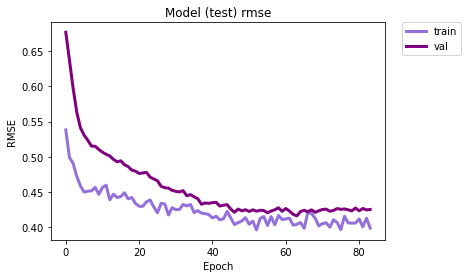

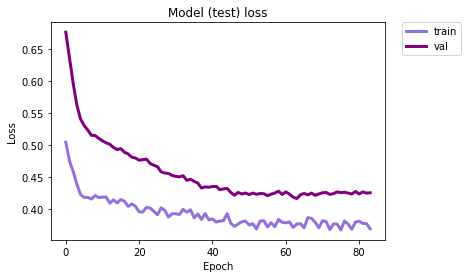

Epoch 1/300
7/7 [==============================] - 0s 76ms/step - loss: 0.4148 - mae: 0.2935 - rmse: 0.4237 - val_loss: 0.4194 - val_mae: 0.2864 - val_rmse: 0.2440
Epoch 2/300
7/7 [==============================] - 0s 54ms/step - loss: 0.4202 - mae: 0.2935 - rmse: 0.4295 - val_loss: 0.4171 - val_mae: 0.2855 - val_rmse: 0.2413
Epoch 3/300
7/7 [==============================] - 0s 55ms/step - loss: 0.4119 - mae: 0.2934 - rmse: 0.4207 - val_loss: 0.4151 - val_mae: 0.2849 - val_rmse: 0.2395
Epoch 4/300
7/7 [==============================] - 0s 55ms/step - loss: 0.4034 - mae: 0.2866 - rmse: 0.4115 - val_loss: 0.4073 - val_mae: 0.2825 - val_rmse: 0.2336
Epoch 5/300
7/7 [==============================] - 0s 65ms/step - loss: 0.4079 - mae: 0.2932 - rmse: 0.4152 - val_loss: 0.4106 - val_mae: 0.2834 - val_rmse: 0.2355
Epoch 6/300
7/7 [==============================] - 1s 80ms/step - loss: 0.4123 - mae: 0.2949 - rmse: 0.4208 - val_loss: 0.4070 - val_mae: 0.2824 - val_rmse: 0.2327
Epoch 7/300
7/7 

Epoch 51/300
7/7 [==============================] - 0s 61ms/step - loss: 0.3882 - mae: 0.2809 - rmse: 0.3959 - val_loss: 0.3791 - val_mae: 0.2706 - val_rmse: 0.2160
Epoch 52/300
7/7 [==============================] - 1s 76ms/step - loss: 0.3896 - mae: 0.2803 - rmse: 0.3949 - val_loss: 0.3774 - val_mae: 0.2711 - val_rmse: 0.2147
Epoch 53/300
7/7 [==============================] - 0s 51ms/step - loss: 0.3884 - mae: 0.2839 - rmse: 0.3922 - val_loss: 0.3774 - val_mae: 0.2707 - val_rmse: 0.2164
Epoch 54/300
7/7 [==============================] - 0s 46ms/step - loss: 0.3901 - mae: 0.2789 - rmse: 0.3945 - val_loss: 0.3775 - val_mae: 0.2705 - val_rmse: 0.2172
Epoch 55/300
7/7 [==============================] - 0s 47ms/step - loss: 0.3884 - mae: 0.2737 - rmse: 0.3917 - val_loss: 0.3746 - val_mae: 0.2704 - val_rmse: 0.2155
Epoch 56/300
7/7 [==============================] - 0s 51ms/step - loss: 0.3900 - mae: 0.2780 - rmse: 0.3957 - val_loss: 0.3745 - val_mae: 0.2695 - val_rmse: 0.2152
Epoch 57/3

Epoch 101/300
7/7 [==============================] - 0s 64ms/step - loss: 0.3609 - mae: 0.2586 - rmse: 0.3552 - val_loss: 0.3264 - val_mae: 0.2554 - val_rmse: 0.1921
Epoch 102/300
7/7 [==============================] - 1s 83ms/step - loss: 0.3735 - mae: 0.2622 - rmse: 0.3651 - val_loss: 0.3262 - val_mae: 0.2528 - val_rmse: 0.1936
Epoch 103/300
7/7 [==============================] - 0s 62ms/step - loss: 0.3574 - mae: 0.2481 - rmse: 0.3528 - val_loss: 0.3238 - val_mae: 0.2564 - val_rmse: 0.1910
Epoch 104/300
7/7 [==============================] - 0s 71ms/step - loss: 0.3536 - mae: 0.2505 - rmse: 0.3477 - val_loss: 0.3170 - val_mae: 0.2557 - val_rmse: 0.1893
Epoch 105/300
7/7 [==============================] - 0s 54ms/step - loss: 0.3508 - mae: 0.2442 - rmse: 0.3461 - val_loss: 0.3198 - val_mae: 0.2506 - val_rmse: 0.1920
Epoch 106/300
7/7 [==============================] - 0s 67ms/step - loss: 0.3875 - mae: 0.2646 - rmse: 0.3852 - val_loss: 0.3221 - val_mae: 0.2523 - val_rmse: 0.1916
Epoc

7/7 [==============================] - 0s 56ms/step - loss: 0.3504 - mae: 0.2509 - rmse: 0.3368 - val_loss: 0.2767 - val_mae: 0.2255 - val_rmse: 0.1685
Epoch 151/300
7/7 [==============================] - 0s 59ms/step - loss: 0.3370 - mae: 0.2294 - rmse: 0.3313 - val_loss: 0.2712 - val_mae: 0.2276 - val_rmse: 0.1613
Epoch 152/300
7/7 [==============================] - 1s 74ms/step - loss: 0.3445 - mae: 0.2436 - rmse: 0.3305 - val_loss: 0.2821 - val_mae: 0.2318 - val_rmse: 0.1642
Epoch 153/300
7/7 [==============================] - 0s 62ms/step - loss: 0.3418 - mae: 0.2386 - rmse: 0.3348 - val_loss: 0.2758 - val_mae: 0.2268 - val_rmse: 0.1674
Epoch 154/300
7/7 [==============================] - 0s 72ms/step - loss: 0.3261 - mae: 0.2286 - rmse: 0.3108 - val_loss: 0.2850 - val_mae: 0.2346 - val_rmse: 0.1661
Epoch 155/300
7/7 [==============================] - 0s 52ms/step - loss: 0.3562 - mae: 0.2570 - rmse: 0.3438 - val_loss: 0.2721 - val_mae: 0.2283 - val_rmse: 0.1637
Epoch 156/300
7/7 

7/7 [==============================] - 0s 49ms/step - loss: 0.3455 - mae: 0.2384 - rmse: 0.3296 - val_loss: 0.2611 - val_mae: 0.2170 - val_rmse: 0.1559
Epoch 200/300
7/7 [==============================] - 0s 49ms/step - loss: 0.3304 - mae: 0.2388 - rmse: 0.3107 - val_loss: 0.3008 - val_mae: 0.2427 - val_rmse: 0.1731
Epoch 201/300
7/7 [==============================] - 0s 58ms/step - loss: 0.3350 - mae: 0.2434 - rmse: 0.3119 - val_loss: 0.2677 - val_mae: 0.2261 - val_rmse: 0.1539
Epoch 202/300
7/7 [==============================] - 0s 49ms/step - loss: 0.3265 - mae: 0.2378 - rmse: 0.3105 - val_loss: 0.2573 - val_mae: 0.2163 - val_rmse: 0.1530
Epoch 203/300
7/7 [==============================] - 0s 52ms/step - loss: 0.3364 - mae: 0.2366 - rmse: 0.3167 - val_loss: 0.2702 - val_mae: 0.2273 - val_rmse: 0.1551
Epoch 204/300
7/7 [==============================] - 0s 50ms/step - loss: 0.3367 - mae: 0.2366 - rmse: 0.3297 - val_loss: 0.3112 - val_mae: 0.2466 - val_rmse: 0.1827
Epoch 205/300
7/7 

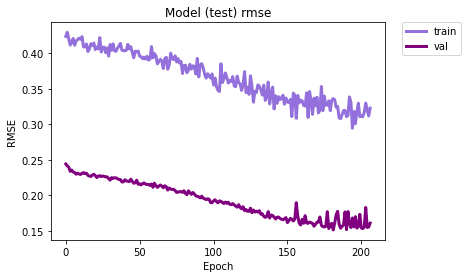

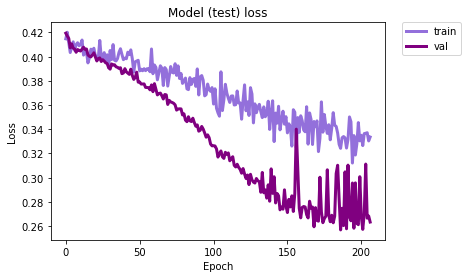

Epoch 1/300
9/9 [==============================] - 1s 92ms/step - loss: 0.3070 - mae: 0.2209 - rmse: 0.2991 - val_loss: 0.2900 - val_mae: 0.1890 - val_rmse: 0.3415
Epoch 2/300
9/9 [==============================] - 1s 57ms/step - loss: 0.3300 - mae: 0.2345 - rmse: 0.3225 - val_loss: 0.2888 - val_mae: 0.1875 - val_rmse: 0.3393
Epoch 3/300
9/9 [==============================] - 0s 47ms/step - loss: 0.3185 - mae: 0.2283 - rmse: 0.3065 - val_loss: 0.2916 - val_mae: 0.1891 - val_rmse: 0.3440
Epoch 4/300
9/9 [==============================] - 0s 47ms/step - loss: 0.3129 - mae: 0.2286 - rmse: 0.2988 - val_loss: 0.2889 - val_mae: 0.1896 - val_rmse: 0.3403
Epoch 5/300
9/9 [==============================] - 0s 46ms/step - loss: 0.3232 - mae: 0.2327 - rmse: 0.3085 - val_loss: 0.2909 - val_mae: 0.1906 - val_rmse: 0.3432
Epoch 6/300
9/9 [==============================] - 0s 47ms/step - loss: 0.3224 - mae: 0.2295 - rmse: 0.3121 - val_loss: 0.3019 - val_mae: 0.1951 - val_rmse: 0.3591
Epoch 7/300
9/9 

Epoch 51/300
9/9 [==============================] - 1s 92ms/step - loss: 0.3163 - mae: 0.2286 - rmse: 0.3046 - val_loss: 0.2888 - val_mae: 0.1861 - val_rmse: 0.3388
Epoch 52/300
9/9 [==============================] - 1s 75ms/step - loss: 0.3138 - mae: 0.2233 - rmse: 0.3035 - val_loss: 0.2816 - val_mae: 0.1854 - val_rmse: 0.3281
Epoch 53/300
9/9 [==============================] - 1s 80ms/step - loss: 0.3154 - mae: 0.2314 - rmse: 0.3021 - val_loss: 0.2853 - val_mae: 0.1863 - val_rmse: 0.3333
Epoch 54/300
9/9 [==============================] - 1s 93ms/step - loss: 0.3184 - mae: 0.2296 - rmse: 0.3038 - val_loss: 0.2819 - val_mae: 0.1861 - val_rmse: 0.3274
Epoch 55/300
9/9 [==============================] - 1s 95ms/step - loss: 0.3018 - mae: 0.2179 - rmse: 0.2930 - val_loss: 0.2928 - val_mae: 0.1880 - val_rmse: 0.3447
Epoch 56/300
9/9 [==============================] - 1s 82ms/step - loss: 0.3202 - mae: 0.2272 - rmse: 0.3056 - val_loss: 0.2805 - val_mae: 0.1850 - val_rmse: 0.3256
Epoch 57/3

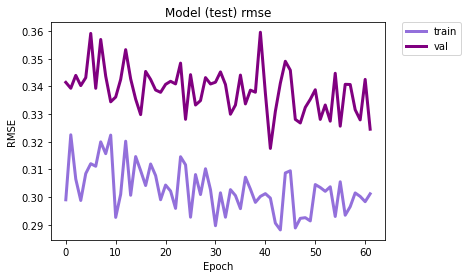

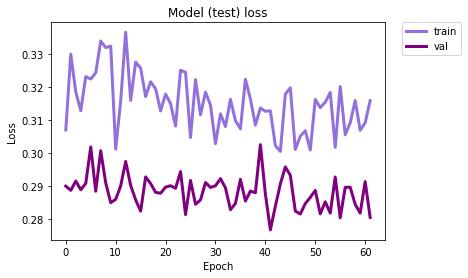

Epoch 1/300
11/11 [==============================] - 1s 62ms/step - loss: 0.3161 - mae: 0.2247 - rmse: 0.3211 - val_loss: 0.3277 - val_mae: 0.2558 - val_rmse: 0.3273
Epoch 2/300
11/11 [==============================] - 1s 53ms/step - loss: 0.3224 - mae: 0.2339 - rmse: 0.3254 - val_loss: 0.3420 - val_mae: 0.2661 - val_rmse: 0.3422
Epoch 3/300
11/11 [==============================] - 1s 51ms/step - loss: 0.3240 - mae: 0.2371 - rmse: 0.3260 - val_loss: 0.3282 - val_mae: 0.2571 - val_rmse: 0.3280
Epoch 4/300
11/11 [==============================] - 1s 49ms/step - loss: 0.3195 - mae: 0.2344 - rmse: 0.3239 - val_loss: 0.3315 - val_mae: 0.2595 - val_rmse: 0.3314
Epoch 5/300
11/11 [==============================] - 1s 65ms/step - loss: 0.3220 - mae: 0.2371 - rmse: 0.3281 - val_loss: 0.3290 - val_mae: 0.2548 - val_rmse: 0.3287
Epoch 6/300
11/11 [==============================] - 1s 54ms/step - loss: 0.3215 - mae: 0.2328 - rmse: 0.3212 - val_loss: 0.3247 - val_mae: 0.2512 - val_rmse: 0.3244
Epoc

11/11 [==============================] - 1s 47ms/step - loss: 0.3147 - mae: 0.2231 - rmse: 0.3163 - val_loss: 0.3109 - val_mae: 0.2403 - val_rmse: 0.3117
Epoch 51/300
11/11 [==============================] - 0s 45ms/step - loss: 0.3087 - mae: 0.2235 - rmse: 0.3085 - val_loss: 0.3101 - val_mae: 0.2387 - val_rmse: 0.3108
Epoch 52/300
11/11 [==============================] - 0s 44ms/step - loss: 0.3123 - mae: 0.2244 - rmse: 0.3073 - val_loss: 0.3207 - val_mae: 0.2496 - val_rmse: 0.3220
Epoch 53/300
11/11 [==============================] - 0s 44ms/step - loss: 0.2912 - mae: 0.2074 - rmse: 0.2860 - val_loss: 0.3124 - val_mae: 0.2416 - val_rmse: 0.3135
Epoch 54/300
11/11 [==============================] - 1s 47ms/step - loss: 0.3071 - mae: 0.2190 - rmse: 0.3080 - val_loss: 0.3246 - val_mae: 0.2568 - val_rmse: 0.3259
Epoch 55/300
11/11 [==============================] - 1s 47ms/step - loss: 0.2998 - mae: 0.2136 - rmse: 0.2949 - val_loss: 0.3139 - val_mae: 0.2395 - val_rmse: 0.3149
Epoch 56/30

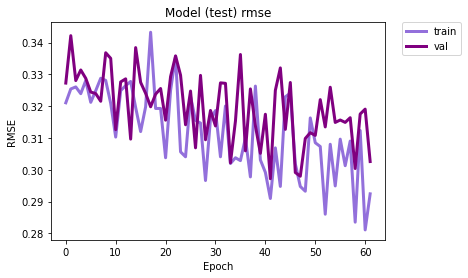

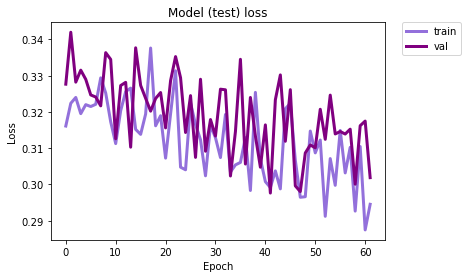

In [21]:
# fitting the model
modelSpeed = build_model(TIMESTEPS, FEATURES, name = 'test')
modelSpeed , hist_list, loss_list = compile_and_fit(modelSpeed, x, y, EPOCHS, BATCH_SIZE, CV_SPLITS)

yhat 0.5607682
Transformed yhat 46.45142
yhat 0.5584752
Transformed yhat 46.427673
yhat 0.5629641
Transformed yhat 46.47416
yhat 0.54553753
Transformed yhat 46.293694
yhat 0.49853918
Transformed yhat 45.806988
yhat 0.4212118
Transformed yhat 45.006207
yhat 0.30603376
Transformed yhat 43.813446
yhat 0.20785242
Transformed yhat 42.796703
yhat 0.22772594
Transformed yhat 43.002506
yhat 0.43552583
Transformed yhat 45.154434
yhat 0.65782297
Transformed yhat 47.456493
yhat 0.80933434
Transformed yhat 49.025513
Real data: [44.56862745 41.52941176 44.82692308 47.15686275 43.62745098 42.55769231
 34.90196078 35.61538462 39.21568627 46.98039216 48.44230769 49.2745098
 50.         50.         50.         50.         50.         50.
 50.         50.         50.         50.         45.96078431 45.7       ]
Forecasting values: [46.5, 46.4, 46.5, 46.3, 45.8, 45.0, 43.8, 42.8, 43.0, 45.2, 47.5, 49.0]


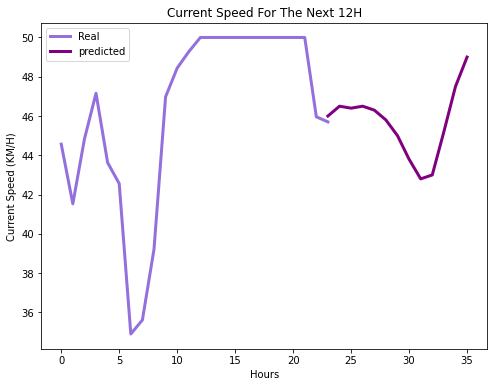

In [22]:
# Recursive Multi-step Forecast
forecastSpeed = forecast(modelSpeed,normalized_Speed, scaler, TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

plot_prediction_Speed(normalized_Speed, forecastSpeed, scaler)

In [23]:
hour = []
ts = traffic.iloc[-1]['timeStamp']
tss = pd.to_datetime(ts).hour

for i in range(12):
    if tss == 23:
        newHour =  ts + pd.DateOffset(hour=0)
        day = pd.to_datetime(ts).day
        newDay = newHour + pd.DateOffset(day=day+1)
        tss = 0
        ts = newDay
        hour.append(newDay)
    else: 
        h = pd.to_datetime(ts).hour
        newHour = ts + pd.DateOffset(hour=h+1)
        tss = tss+1
        ts = newHour
        hour.append(newHour)

In [24]:
import csv

with open('predictionsSpeed.csv', mode='a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(12):
        d = 'N103.2',forecastSpeed[i],hour[i]
        writer.writerow(d)